In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [4]:
climbuserdf=pd.read_csv("../fin_proj_dfs/finalproject-sorted_climbuserdf.csv")
climbuserdf.head()

IOError: File finalproject-sorted_climbuserdf.csv does not exist

In [ ]:
userdf=pd.read_csv("../fin_proj_dfs/finalproject-users.csv")
#userdf.head()

In [ ]:
# create function to figure out common support

def compute_supports(df):
    users=df.user_id.unique()
    climbs = df.groupby('climb_id').user_id.unique()
    bdict={}
    for e,v in zip(climbs.index.values, rests.values):
        bdict[e] = np.array([item in v for item in users])
    climb_list=bdict.keys()
    supports=[]
    for i,climb1 in enumerate(climb_list):
        for j,climb2 in enumerate(climb_list):
            if  i < j:
                supmask = (bdict[climb1] & bdict[climb2])
                common_reviewers = np.sum(supmask)
                supports.append(common_reviewers)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

# Visualizing Data Sparsity


## User Info

In [ ]:
reviews_user = climbuserdf.groupby('user_id').climb_id.count()
#pd.hist(reviews_user, bins=np.arange(1,100,2), alpha=0.5, label="Reviews per user");
#print sorted(list(reviews_user))
reviews_user.hist(bins=1000, label="# of users with corresponding total", alpha=.5, color='green',log=True)
#plt.ylim([0,10000])
plt.xlim([0,1500])
plt.xlabel('Total # of Climbs Stared, Ticked or Suggested Rating')
plt.ylabel('Number of Users')
plt.legend();

Since there are only 4 users with climb interactions greater than 1500, so we set the xlim on the above chart to 1500

In [ ]:
reviews_user.sort_values(ascending=False)[:5]

Further, we plot the cumulative distribution of ratings per user:

In [ ]:
reviews_user = climbuserdf.groupby('user_id').climb_id.count()
#pd.hist(reviews_user, bins=np.arange(1,100,2), alpha=0.5, label="Reviews per user");
#print sorted(list(reviews_user))
reviews_user.hist(bins=1000, label="Cumulative # of users with more or equal to corresponding total", alpha=.5, color='green',log=True, cumulative=-1)
#plt.ylim([0,10000])
plt.xlim([0,1500])
plt.xlabel('Total # of Climbs Stared, Ticked or Suggested Rating')
plt.ylabel('Cumulative Number of Users')
plt.legend();

Notes:
- there are about 3,000 users with 100 climbs or more
- there are about 1000 users with 200 climbs or more
- there are about 100 users with 600 climbs or more

## Climb Info

In [ ]:
reviews_climb = climbuserdf.groupby('climb_id').user_id.count()
reviews_climb.hist(bins=1000, label="# of climbs with corresponding total", alpha=.6, color='green',log=True)
plt.ylim([-1,1500])
plt.xlim([0,1000])
plt.xlabel('Total # of Users who Stared, Ticked or Suggested Ratings')
plt.ylabel('Number of Climbs')
plt.legend();

As you can see below, there are only 3 climbs with out 1000 ratings, and so we choose to exclude them for better clarity in our plot above.

In [ ]:
reviews_climb.sort_values(ascending=False)[:5]

In [ ]:
reviews_climb = climbuserdf.groupby('climb_id').user_id.count()
reviews_climb.hist(bins=1000, label="Cumulative # of climbs with more or equal to corresponding total", alpha=.6, color='green',log=True, cumulative=-1)
plt.ylim([-1,15000])
plt.xlim([0,1000])
plt.xlabel('Total # of Users who Stared, Ticked or Suggested Rating')
plt.ylabel('Cumulative Number of Climbs')
plt.legend();

In [ ]:
climbuserdf.shape

In [ ]:
#in case there are duplicates, drop them
climbuserdf=climbuserdf.drop_duplicates(['user_id','climb_id'])
climbuserdf.shape

We can see above there are no duplicates in the dataframe. The next step is to make the train, validate, and test sets for our classifiers.

 # Split Data

In [ ]:
#make train, validate, and test sets

trainlist=[]
testlist=[]
validatelist=[]
take=5

for user, user_reviews in climbuserdf.groupby('user_id'):
    #we only want reviewers who have done a lot of reviews
    if len(user_reviews) > 12:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(user_reviews[-take:][~takelist])#use those 
        testlist.append(user_reviews[-take:][takelist])#use the others 
        trainlist.append(user_reviews[:-take])
    else:
        trainlist.append(user_reviews)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

In [ ]:
#decided not to do this part because it was taking forever

# make sure there is no accidental overlap

# testclimbs =testdf.climbid.values 
# trainclimbs = traindf.climbid.values
# np arrays -> python set
#set(testclimbs)
# set difference -> these will be the climbs that aren't present

validates = set(validatedf.climb_id.values)
tests = set(testdf.climb_id.values)
trains = set(traindf.climb_id.values)

In [ ]:
train_test_difs = tests.difference(trains)
train_val_difs = validates.difference(trains)
print len(train_test_difs)
print len(train_val_difs)

In [ ]:
#drop the rows that don't appear in the training set using ids from difference sets
for row in validatedf:
    for climbid in train_val_difs:
        validatedf = validatedf[validatedf.climb_id != climbid]

print validatedf.shape

for row in testdf:
    for climbid in train_test_difs:
        testdf = testdf[testdf.climb_id != climbid]
        
print testdf.shape


In [ ]:

"""
maskval=[e in set(validatedf.climb_id).difference(set(traindf.climb_id)) for e in validatedf.climb_id] 
masktest=[e in set(testdf.climb_id).difference(set(traindf.climb_id)) for e in testdf.climb_id] 
print np.sum(maskval), np.sum(masktest)"""

In [ ]:
"""#drop the rows that don't appear in the training set using ids from difference sets
for index, row in enumerate(validatedf):
    if maskval[index]:
        validatedf = validatedf.drop([row])

for index, row in enumerate(testdf):
    if masktest[index]:
        testdf = testdf.drop([row])"""

In [ ]:
#clean up the validate and test frames

validatedf=validatedf[['user_id', 'climb_id','star_rating', 'Unnamed: 0']]
testdf=testdf[['user_id', 'climb_id', 'star_rating', 'Unnamed: 0']]

In [ ]:
#save the frames

traindf.to_csv("../train.csv", index=False, header=True, encoding="utf-8")
validatedf.to_csv("validate.csv", index=False, header=True, encoding="utf-8")
testdf.to_csv("test.csv", index=False, header=True, encoding="utf-8")

#Make Smaller Dataframes

In [1]:
climbuserdf

NameError: name 'climbuserdf' is not defined

In [ ]:
#make train, validate, and test sets

trainlist=[]
testlist=[]
validatelist=[]
take=5

for user, user_reviews in climbuserdf.groupby('user_id'):
    #we only want reviewers who have done a lot of reviews
    if len(user_reviews) > 12:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(user_reviews[-take:][~takelist])#use those 
        testlist.append(user_reviews[-take:][takelist])#use the others 
        trainlist.append(user_reviews[:-take])
    else:
        trainlist.append(user_reviews)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

# Baseline Model

## Get Biases

In [373]:
#get the overall average

ybar = traindf.star_rating.mean()
ybar

2.7885822617870097

In [246]:
userids=traindf.user_id.unique()#unique-user-ids
climbids=traindf.climb_id.unique()#unique-item-ids

In [247]:
useridmap={v:k for k,v in enumerate(userids)}#of length U
climbidmap={v:k for k,v in enumerate(climbids)}#of length M

In [248]:
#calculate the user and climb biases

user_biases = {user_id : (traindf[traindf.user_id == user_id].star_rating.mean() - ybar) for user_id in userids}
climb_biases = {climb_id : (traindf[traindf.climb_id == climb_id].star_rating.mean() - ybar) for climb_id in climbids}

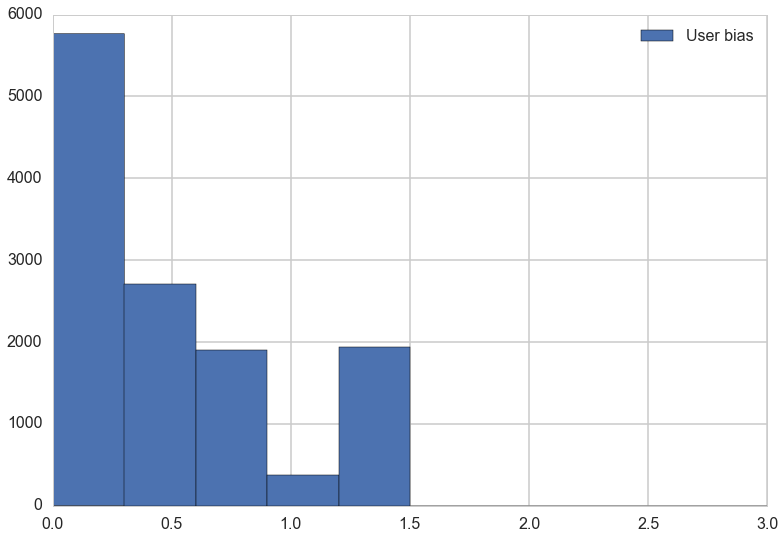

In [337]:
#let's make histograms of the user biases cuz why not

user_bias = user_biases.values()
total_user_bias = 0
for bias in user_bias:
    total_user_bias += bias
mean_user_bias = np.mean(user_bias)
median_user_bias = np.median(user_bias)
plt.hist(user_bias, range=(0,3), label="User bias");
plt.legend()
plt.axvline(mean_user_bias, color='b', linestyle='dashed', linewidth=2, label = "mean")
plt.axvline(median_user_bias, color='r', linestyle='solid', linewidth=2, label = "median")

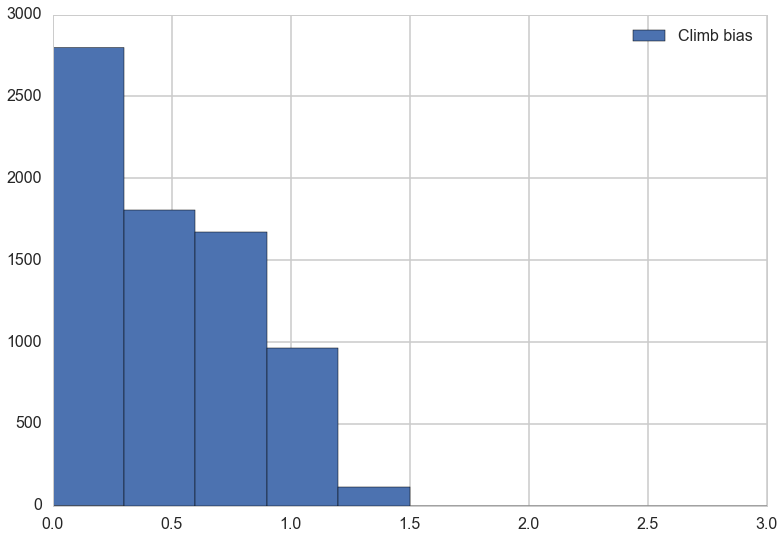

In [343]:
#same with climb biases

climb_bias = climb_biases.values()
total_climb_bias = 0
for bias in climb_bias:
    total_climb_bias += bias
mean_climb_bias = np.mean(climb_bias)
median_climb_bias = np.median(climb_bias)
plt.hist(climb_bias, range=(0,3), label="Climb bias");
plt.legend()
plt.axvline(mean_climb_bias, color='b', linestyle='dashed', linewidth=2, label = "mean")
plt.axvline(median_climb_bias, color='r', linestyle='solid', linewidth=2, label = "median")

In [251]:
#save the averages for use in the equation

train_avgs={'mean':ybar, 'users':user_biases, 'climbs':climb_biases}

In [374]:
#instantiate the prediction sets

predictions={}
predictions_valid={}

In [234]:
"""print traindf[traindf.climb_id == 105717673]
#traindf.head()"""

'print traindf[traindf.climb_id == 105717673]\n#traindf.head()'

## Make Predictions

In [377]:
#make predictions!

predictions["baseline"] = []
for index, row in testdf.iterrows():
    user = row["user_id"]
    climb = row["climb_id"]
    prediction = ybar + (user_biases[user]) + (climb_biases[climb])
    predictions["baseline"].append(prediction)
    
predictions_valid["baseline"] = []
for index, row in validatedf.iterrows():
    user = row["user_id"]
    climb = row["climb_id"]
    prediction = ybar + (user_biases[user]) + (climb_biases[climb])
    predictions_valid["baseline"].append(prediction)

In [376]:
predictions_valid["baseline"]

[2.379180896107727,
 3.180406287831311,
 2.0572510715463235,
 2.843621128043499,
 2.8890756734980445,
 3.173032892749381,
 3.485659811807066,
 2.873083746898344,
 4.220142570427756,
 2.3661796429748954,
 2.8549920354017453,
 3.2525823968475285,
 3.265963192758445,
 2.353084404879657,
 2.728084404879657,
 4.209178096555656,
 3.5267827636798836,
 3.0570791891375992,
 1.4257034524987044,
 2.0244258682942915,
 0.4738290857307208,
 4.038690465485717,
 3.6053571321523843,
 3.1386904654857175,
 2.578939105734358,
 2.866201978363084,
 3.7207015578416374,
 2.846338373133625,
 3.346338373133625,
 4.179671706466959,
 1.9537254305206826,
 1.51141773821299,
 2.1874177382129902,
 5.152594208801226,
 4.142452220971611,
 4.925703452498705,
 2.7306303068293065,
 1.7792414179404177,
 2.2417414179404176,
 1.7030936538622687,
 2.840348555823053,
 0.9736818891563865,
 3.2156912424864945,
 2.3268023535976057,
 2.4268023535976058,
 2.006773326021408,
 1.865263892059144,
 2.0319305587258105,
 2.58303935983461

## Analyze Results

In [378]:
#make a swaggadocious get_rmse function
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [386]:
def compare_results(stars_actual, stars_predicted, ylow=1, yhigh=6, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([1,5],[1,5], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.9, 4.1])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline nan


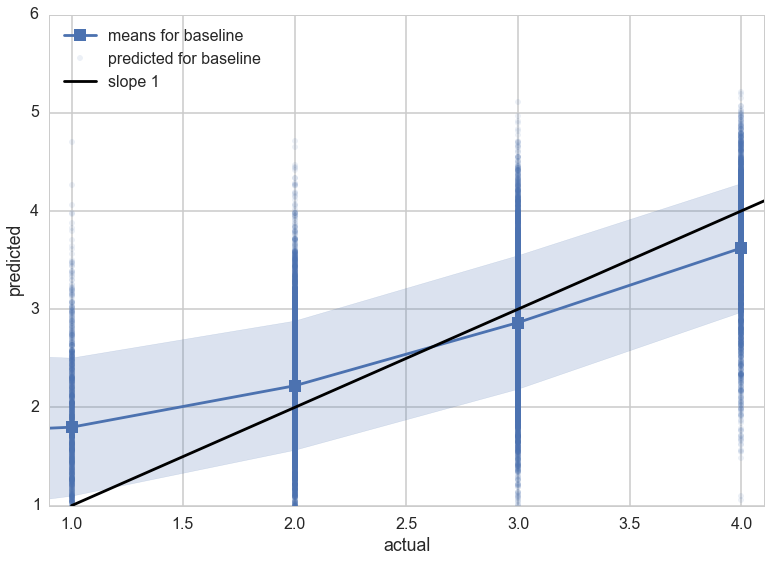

In [387]:
compare_results(testdf.star_rating, predictions['baseline'], model="baseline", predicteds=True);

# Knn Model

Yay! That's the baseline prediction. Done with that, time to move on to K-nearest neighbors.

In [381]:
#for each climb get the unique userids who rated it
users_for_climbs = traindf.groupby('climb_id').user_id.unique()
climbs=climbids
lclimbs=len(climbs)
supports=[[[] for i in range(climbs)] for i in range(lclimbs)]
supporthistlist=[]
for i,climb1 in enumerate(climbs):
    for j,climb2 in enumerate(climbs):
        if  i <= j:#its symmetric
            if climb1==climb2:
                common_reviewers=users_for_climbs[climbs]
            else:
                common_reviewers = set(users_for_climbs[climb1]).intersection(set(users_for_climbs[climb2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
def pearson_sim(climb1_reviews, cilmb2_reviews, n_common):
    if n_common == 0:
        return 0
    else:
        ratings1 = []
        ratings2 = []
        if isinstance(climb1_reviews, pd.DataFrame):
            for user in climb1_reviews["user_id"]:
                stars1 = climb1_reviews[climb1_reviews.user_id == user].star_rating
                stars1 = stars1[stars1.index[0]]
                stars2 = rest2_reviews[climb2_reviews.user_id == user].star_rating
                stars2 = stars2[stars2.index[0]]
                ratings1.append(stars1 - user_biases[user])
                ratings2.append(stars2 - user_biases[user])

        if isinstance(climb1_reviews, dict):
            for user in climb1_reviews.iterkeys():
                ratings1.append(climb1_reviews[user] - user_biases[user])
                ratings2.append(climb2_reviews[user] - user_biases[user])
            
        pearson = pearsonr(ratings1, ratings2)
        pearson = pearson[0]
        if math.isnan(pearson):
            return 0
        else:
            return pearson

In [ ]:
def get_climb_reviews(climb_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.climb_id==climb_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

In [ ]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, climb1, climb2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

In [ ]:
db=Database(climbidmap, supports)

In [ ]:
#put user average ratings in climbuserdf so that the next function makes sense
#climbuserdf["user_avg"] = np.mean((climbuserdf[] for user in climbuserdf.user_id)

In [ ]:
# each row looks like: user_id, (climb_id, star_rating, user_avg). The row indices need to
# be altered to reflect the way our data looks.
def mapper1(row):
    return row[2], (row[1], row[3], row[14])